In [1]:

import pandas as pd
import numpy as np


In [2]:
df = pd.read_feather('train_data_withOneHot.feather')


In [3]:
df.head()

,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,POSTCODE,BLDFRONT,...,EXMPTCL_R4,EXMPTCL_X1,EXMPTCL_X2,EXMPTCL_X3,EXMPTCL_X4,EXMPTCL_X5,EXMPTCL_X6,EXMPTCL_X7,EXMPTCL_X8,EXMPTCL_X9
60,171,7502,0,0,11.0,0,0,0,10013,0,...,0,0,0,0,0,0,0,0,0,0
61,200,7502,50,100,10.0,0,0,0,10013,50,...,0,0,0,0,0,0,0,0,0,0
62,427,7506,0,0,1.0,0,0,0,10002,0,...,0,0,0,0,0,0,0,0,0,0
63,462,7501,97,90,12.0,0,0,0,10003,0,...,0,0,0,0,0,0,0,0,0,0
64,466,7502,0,121,12.0,0,0,0,10003,105,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8420121 entries, 60 to 9501113
Columns: 349 entries, BLOCK to EXMPTCL_X9
dtypes: float64(3), int16(7), int64(12), int8(327)
memory usage: 3.7 GB


In [5]:
df.columns

Index(['BLOCK', 'LOT', 'LTFRONT', 'LTDEPTH', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'POSTCODE', 'BLDFRONT',
       ...
       'EXMPTCL_R4', 'EXMPTCL_X1', 'EXMPTCL_X2', 'EXMPTCL_X3', 'EXMPTCL_X4',
       'EXMPTCL_X5', 'EXMPTCL_X6', 'EXMPTCL_X7', 'EXMPTCL_X8', 'EXMPTCL_X9'],
      dtype='object', length=349)

In [6]:
for col in df.columns:
    print(col)

BLOCK
LOT
LTFRONT
LTDEPTH
STORIES
FULLVAL
AVLAND
AVTOT
POSTCODE
BLDFRONT
BLDDEPTH
YEAR
Latitude
Longitude
Council District
crime_FELONY
crime_MISDEMEANOR
crime_VIOLATION
ADULT SERVICES__ADULT AND IMMIGRANT LITERACY
CAMPS__CAMPS
CHILD SERVICES AND WELFARE__CHILD NUTRITION
CHILD SERVICES AND WELFARE__FOSTER CARE SERVICES AND RESIDENTIAL CARE
CITY AGENCY PARKING, MAINTENANCE, AND STORAGE__CITY AGENCY PARKING
CITY AGENCY PARKING, MAINTENANCE, AND STORAGE__CUSTODIAL
CITY AGENCY PARKING, MAINTENANCE, AND STORAGE__MAINTENANCE AND GARAGES
CITY AGENCY PARKING, MAINTENANCE, AND STORAGE__STORAGE
CULTURAL INSTITUTIONS__HISTORICAL SOCIETIES
CULTURAL INSTITUTIONS__MUSEUMS
CULTURAL INSTITUTIONS__OTHER CULTURAL INSTITUTIONS
DAY CARE AND PRE-KINDERGARTEN__DAY CARE
DAY CARE AND PRE-KINDERGARTEN__DOE UNIVERSAL PRE-KINDERGARTEN
DAY CARE AND PRE-KINDERGARTEN__HEAD START
DAY CARE AND PRE-KINDERGARTEN__PRESCHOOLS FOR STUDENTS WITH DISABILITIES
EMERGENCY SERVICES__FIRE SERVICES
EMERGENCY SERVICES__OTHER EMERG

In [7]:
df['YEAR'].nunique()

8

In [8]:
df['YEAR'].value_counts()

YEAR
2017    1073344
2016    1066699
2015    1058987
2014    1055588
2013    1049571
2012    1046188
2011    1039629
2010    1030115
Name: count, dtype: int64

In [9]:
print(df.shape)
df.memory_usage(deep=True).sum() / (1024**3)

(8420121, 349)


3.677827072329819

In [10]:
import time, gc, os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Optional: Free memory from earlier steps
gc.collect()

# Sample after filtering by year (safer)
df_2017 = df[df["YEAR"] == 2017]
df_sample = df_2017.sample(n=500_000, random_state=42)

# Set target and features
target = "FULLVAL"
y = df_sample[target].astype("float32").values
X = df_sample.drop(columns=[target])

# Convert only float64 columns to float32
float_cols = X.select_dtypes("float64").columns
X[float_cols] = X[float_cols].astype("float32")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Random Forest model (with parallelism and depth control)
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    n_jobs=min(4, os.cpu_count()),  # safe parallelism
    random_state=42
)

# Fit and time it
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")

# Predict and evaluate
y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²:   {r2:.4f}")



Training time: 1499.28 seconds
MAE:  95,120
RMSE: 6,578,524
R²:   0.7515


C:\Users\kchan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# Predict and evaluate
start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²:   {r2:.4f}")

Prediction time: 0.74 seconds
MAE:  95,120
RMSE: 6,578,524
R²:   0.7515


C:\Users\kchan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Importance
AVTOT,0.681421
prev_yr_fullval,0.191099
AVLAND,0.119742
LTDEPTH,0.001400
LTFRONT,0.000938
BLDFRONT,0.000752
LTSIZE,0.000732
STORIES,0.000580
"OFFICES, TRAINING, AND TESTING__TRAINING AND TESTING",0.000388
SCHOOLS (K-12)__NON-PUBLIC K-12 SCHOOLS,0.000360


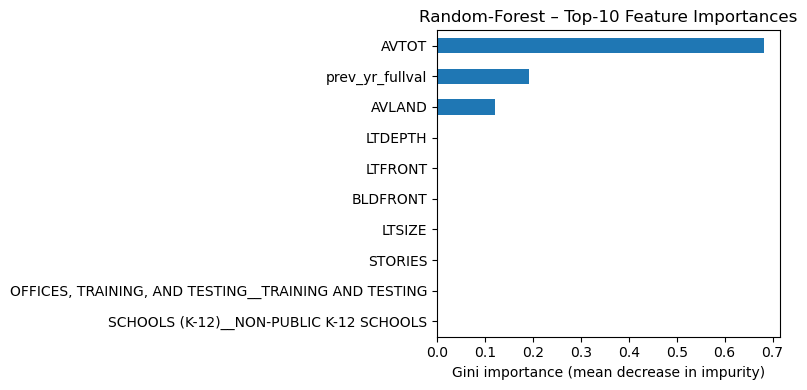

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1  Save feature names *before* X becomes an ndarray
# ------------------------------
feature_names = X.columns.tolist()      # ← keep this safe
# (after this you can still do X = X.astype(np.float32) etc.)

# ------------------------------
# 2  After training, extract importances
# ------------------------------
importances = model.feature_importances_          # 1-D NumPy array
imp_series  = pd.Series(importances, index=feature_names)\
                 .sort_values(ascending=False)

top10 = imp_series.head(10)
display(top10.to_frame('Importance'))

# ------------------------------
# 3  Optional bar chart
# ------------------------------
plt.figure(figsize=(8,4))
top10[::-1].plot(kind='barh')            # reverse so largest is on top
plt.title('Random-Forest – Top-10 Feature Importances')
plt.xlabel('Gini importance (mean decrease in impurity)')
plt.tight_layout()
plt.show()


Mean over-valuation  : -1.95%
> 25% over-valued : 2,328 samples (2.33% of test set)


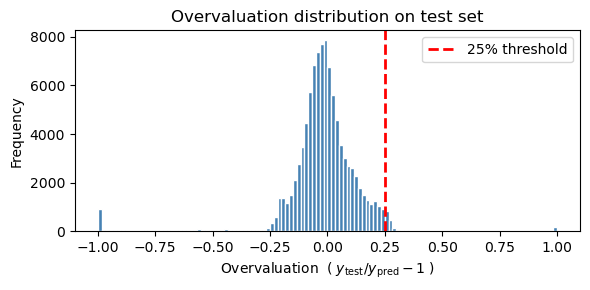

In [13]:
# ── Over-valuation analysis ──────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# 1. ratio  =  (actual / predicted) − 1
ratio_raw = (y_test / y_pred) - 1

# 2. Clip extreme tails to make the histogram readable (±100 %)
ratio = np.clip(ratio_raw, -1.0, 1.0)

# 3. Summary statistics
mean_over = ratio.mean() * 100          # in %
thr       = 0.25                        # 25 % over-valuation threshold
mask      = ratio > thr
n_over    = mask.sum()
pct_over  = n_over / len(ratio) * 100

print(f"Mean over-valuation  : {mean_over:5.2f}%")
print(f"> {thr*100:.0f}% over-valued : {n_over:,} samples "
      f"({pct_over:4.2f}% of test set)")

# 4. Visualise distribution
plt.figure(figsize=(6,3))
plt.hist(ratio, bins=120, color="steelblue", edgecolor="white")
plt.axvline(thr, color="red", lw=2, ls="--", label=f"{thr:.0%} threshold")
plt.xlabel(r"Overvaluation  $(\;y_{\mathrm{test}} / y_{\mathrm{pred}}-1\;)$")
plt.ylabel("Frequency")
plt.title("Overvaluation distribution on test set")
plt.legend();  plt.tight_layout();  plt.show()


In [14]:
import numpy as np

# y_test = true values
# y_pred = predicted values
# You already have these in your code

# RSS
rss = np.sum((y_test - y_pred) ** 2)

# TSS
tss = np.sum((y_test - np.mean(y_test)) ** 2)

# Print both
print(f"RSS: {rss:,.0f}")
print(f"TSS: {tss:,.0f}")

# Optional: verify R²
r2_manual = 1 - (rss / tss)
print(f"R² (manual): {r2_manual:.4f}")


RSS: 4,327,698,203,247,538,176
TSS: 17,416,091,560,646,279,168
R² (manual): 0.7515


In [13]:
ratio_raw

array([-0.16831705, -0.03550773,  0.25828433, ...,  0.02266531,
       -0.074538  ,  0.03426326])

In [14]:
print("X_train shape:", X_train.shape)

X_train shape: (400000, 348)


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
import numpy as np
import time
import time, gc, os
from sklearn.model_selection import train_test_split

df_2017 = df[df["YEAR"] == 2017]
df_sample = df_2017.sample(n=500_000, random_state=42)

# Set target and features
target = "FULLVAL"
y = df_sample[target].astype("float32").values
X = df_sample.drop(columns=[target])

# Convert only float64 columns to float32
float_cols = X.select_dtypes("float64").columns
X[float_cols] = X[float_cols].astype("float32")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Step 1: Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 25],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # removed 'auto'
}


# Step 2: Initialize model
rf = RandomForestRegressor(random_state=42)

# Step 3: Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # You can increase to 50 if time allows
    scoring='neg_mean_absolute_error',  # Tuning for MAE
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Step 4: Fit
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

print(f"Tuning time: {end - start:.2f} seconds")
print("Best Parameters:", random_search.best_params_)

# Step 5: Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²: {r2:.4f}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tuning time: 1115.91 seconds
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}
MAE: 262,821
RMSE: 9,145,133
R²: 0.5198


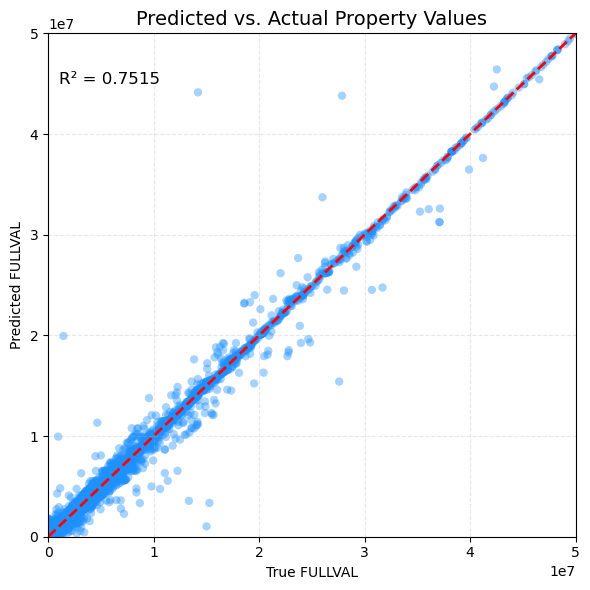

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='dodgerblue', edgecolors='none')

# Ideal prediction line
line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(line, line, color='red', linestyle='--', linewidth=2)

# Set axis limits to zoom in (adjust if needed)
plt.xlim(0, 5e7)  # e.g., $50M
plt.ylim(0, 5e7)

# Add R² text
r2 = r2_score(y_test, y_pred)
plt.text(1e6, 4.5e7, f"R² = {r2:.4f}", fontsize=12, color='black')

# Labels and title
plt.title("Predicted vs. Actual Property Values", fontsize=14)
plt.xlabel("True FULLVAL")
plt.ylabel("Predicted FULLVAL")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
import shap
import matplotlib.pyplot as plt

# Step 1: Create SHAP explainer
explainer = shap.Explainer(model, X_train)  # model = your trained RandomForestRegressor

# Step 2: Calculate SHAP values
shap_values = explainer(X_test)

# Step 3: Summary Plot (Beeswarm)
shap.summary_plot(shap_values, X_test, plot_type="dot")  # This gives the beeswarm plot

# Step 4: Waterfall Plot for a single prediction
# Pick a sample index (you can choose one with high overvaluation)
sample_idx = 0  # or any index of interest
shap.plots.waterfall(shap_values[sample_idx])


ModuleNotFoundError: No module named 'shap'

In [15]:
!pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 9.1 MB/s eta 0:00:00


100%|===================| 99971/100000 [12:46<00:00]        

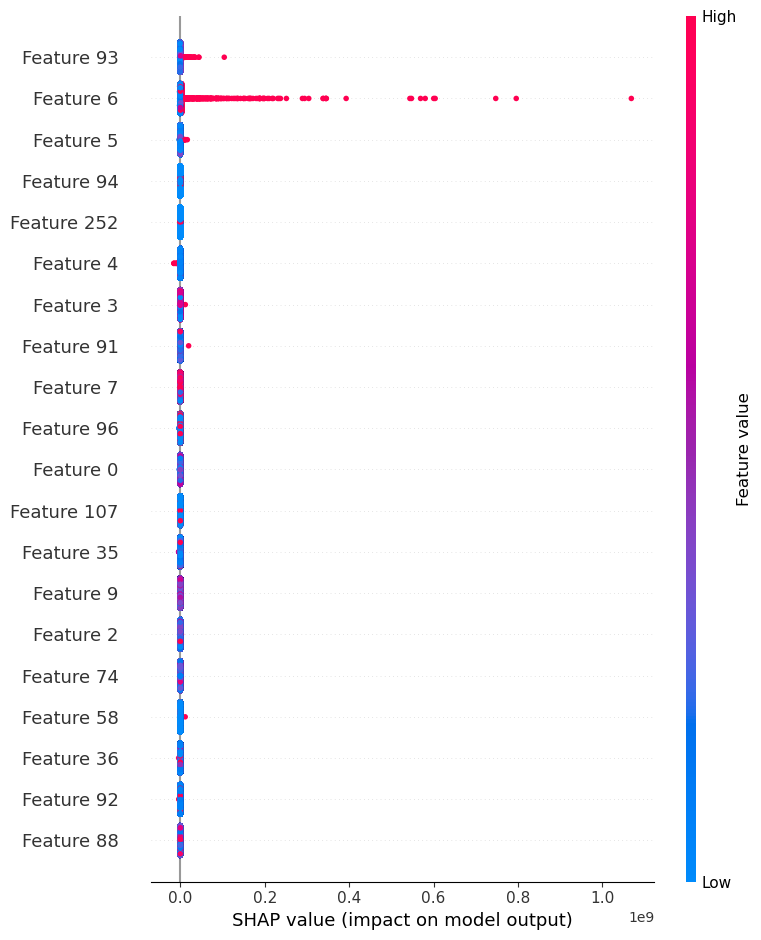

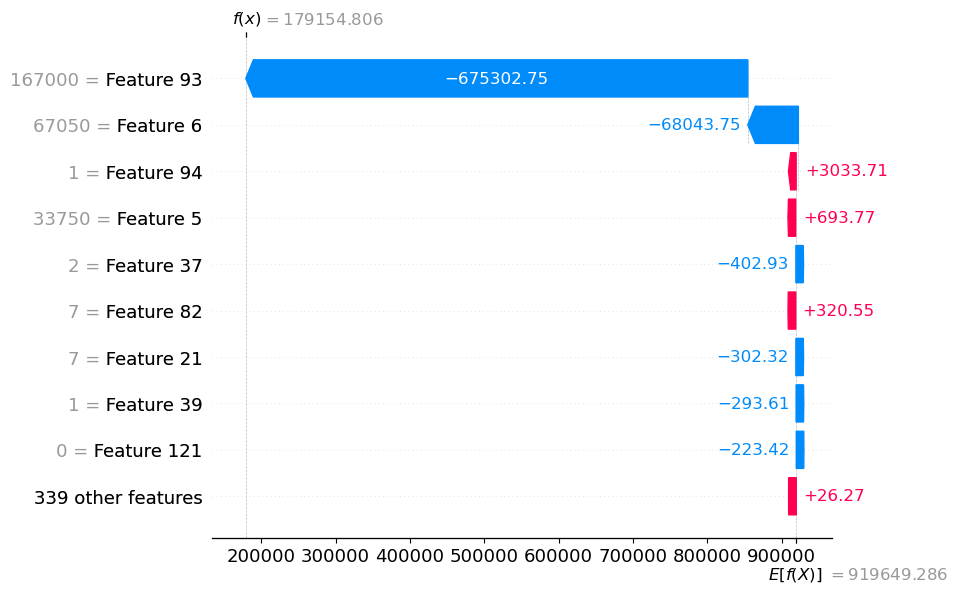

In [16]:
import shap
import matplotlib.pyplot as plt

# Step 1: Create SHAP explainer
explainer = shap.Explainer(model, X_train)  # Replace 'model' and 'X_train' with your variables

# Step 2: Calculate SHAP values
shap_values = explainer(X_test)

# Step 3: Beeswarm summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot")

# Step 4: Waterfall plot for a selected sample
sample_idx = 0  # or any specific index
shap.plots.waterfall(shap_values[sample_idx])
